In [365]:
# Imoports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [366]:
# Connect SQLite database.
db_conn = sqlite3.connect("SuperstoreDB/superstore.db")

In [367]:
# Load all the data from the db into a pandas df.
df = pd.read_sql(
    """
    SELECT *
    FROM OrdersDetails
    JOIN Products
        ON Products.ProductID = OrdersDetails.ProductID
    JOIN Orders
        ON Orders.OrderID = OrdersDetails.OrderID
    JOIN Customers
        ON Customers.CustomerID = Orders.CustomerID
    JOIN Addresses
        ON Addresses.AddressID = Orders.AddressID
    """, db_conn)

In [368]:
# Since we have done 4 JOINs loading the data, we now have duplicated columns. Let's drop them.
# Drop columns with duplicated names.
df = df.loc[:, ~df.columns.duplicated()]

In [369]:
# Converting Sales and Profit from Cents to Dollars.
df['Sales'] = df['Sales'] / 100
df['Profit'] = df['Profit'] / 100

In [370]:
df.head()

,OrderID,ProductID,Sales,Quantity,Discount,Profit,ProductName,Category,SubCategory,OrderDate,...,ShipMode,CustomerID,AddressID,CustomerName,Segment,PostalCode,City,State,Region,Country
0,CA-2016-152156,FUR-BO-10001798,261.95,2,0.00,41.91,Bush Somerset Collection Bookcase,Furniture,Bookcases,2016-11-08,...,Second Class,CG-12520,42420-000001,Claire Gute,Consumer,42420,Henderson,Kentucky,South,United States
1,CA-2016-152156,FUR-CH-10000454,731.94,3,0.00,219.58,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",Furniture,Chairs,2016-11-08,...,Second Class,CG-12520,42420-000001,Claire Gute,Consumer,42420,Henderson,Kentucky,South,United States
2,CA-2016-138688,OFF-LA-10000240,14.62,2,0.00,6.87,Self-Adhesive Address Labels for Typewriters b...,Office Supplies,Labels,2016-06-12,...,Second Class,DV-13045,90036-000001,Darrin Van Huff,Corporate,90036,Los Angeles,California,West,United States
3,US-2015-108966,FUR-TA-10000577,957.57,5,0.45,-383.03,Bretford CR4500 Series Slim Rectangular Table,Furniture,Tables,2015-10-11,...,Standard Class,SO-20335,33311-000001,Sean O'Donnell,Consumer,33311,Fort Lauderdale,Florida,South,United States
4,US-2015-108966,OFF-ST-10000760,22.36,2,0.20,2.51,Eldon Fold 'N Roll Cart System,Office Supplies,Storage,2015-10-11,...,Standard Class,SO-20335,33311-000001,Sean O'Donnell,Consumer,33311,Fort Lauderdale,Florida,South,United States


When working with sales data, a common thing to do is to understand the customers' buying patterns using 3 parameters: Monetary (amount of money spent), Frequency (how frequently the customer bought something) Recency (how many days has passed from today to their last purchase).

These parameters are not given to us; we will have to calculate them.

In [371]:
# First, we will create a new DataFrame by grouping the customers based on their ID and summing the Sales column.
df_monetary = df.groupby('CustomerID', as_index=False)['Sales'].sum()
df_monetary.head()

,CustomerID,Sales
0,AA-10315,5563.54
1,AA-10375,1056.36
2,AA-10480,1790.51
3,AA-10645,5086.90
4,AB-10015,886.15


Do the same with Frequency (How many unique Order IDs are there per customer?) and the Recency (Calculate it from the last order date in the dataset) and then merge all the 3 DataFrames.

In [372]:
# Calculate Frequency (How many unique Order IDs are there per customer?)
df_frequency = df.groupby('CustomerID', as_index=False)['OrderID'].count()
df_frequency.head()

,CustomerID,OrderID
0,AA-10315,11
1,AA-10375,15
2,AA-10480,12
3,AA-10645,18
4,AB-10015,6


In [373]:
# Calculate Recency (today (2017-12-30) - the last order date in the dataset)
df['OrderDate'] = pd.to_datetime(df['OrderDate'])                               # Convert OrderDate to datetime values
df_recency = df.groupby('CustomerID', as_index=False)['OrderDate'].max()        # Find last order date for each customer
df_recency['Recency'] = pd.to_datetime('2017-12-30') - df_recency['OrderDate']  # Calculate Recency
df_recency['Recency'] = df_recency['Recency'].dt.days.astype(int)               # Covert from timedelta64 days to int
df_recency.drop(['OrderDate'], axis=1, inplace=True)                            # Remove unnecessary columns
df_recency.head()

,CustomerID,Recency
0,AA-10315,184
1,AA-10375,19
2,AA-10480,259
3,AA-10645,55
4,AB-10015,415


In [374]:
# Merge all the 3 DataFrames and give the columns better names.
rfm_df = pd.merge(pd.merge(df_monetary,df_frequency,on='CustomerID'),df_recency,on='CustomerID')
rfm_df.rename(columns={'Sales': 'Amount',
                       'OrderID': 'Frequency'},
                       inplace=True)
rfm_df

,CustomerID,Amount,Frequency,Recency
0,AA-10315,5563.54,11,184
1,AA-10375,1056.36,15,19
2,AA-10480,1790.51,12,259
3,AA-10645,5086.90,18,55
4,AB-10015,886.15,6,415
...,...,...,...,...
788,XP-21865,2374.62,28,43
789,YC-21895,5454.34,8,4
790,YS-21880,6720.43,12,9
791,ZC-21910,8025.63,31,54


### Dealing with outliers
Because of its nature, the K-Means algorithm is susceptible to outliers. To check the consequences of having outliers when using a K-Means algorithm, read this article: [Effect of outliers on K-Means algorithm using Python](https://medium.com/analytics-vidhya/effect-of-outliers-on-k-means-algorithm-using-python-7ba85821ea23)


Visualize with a boxplot the 3 parameters and check if there are any outliers there.

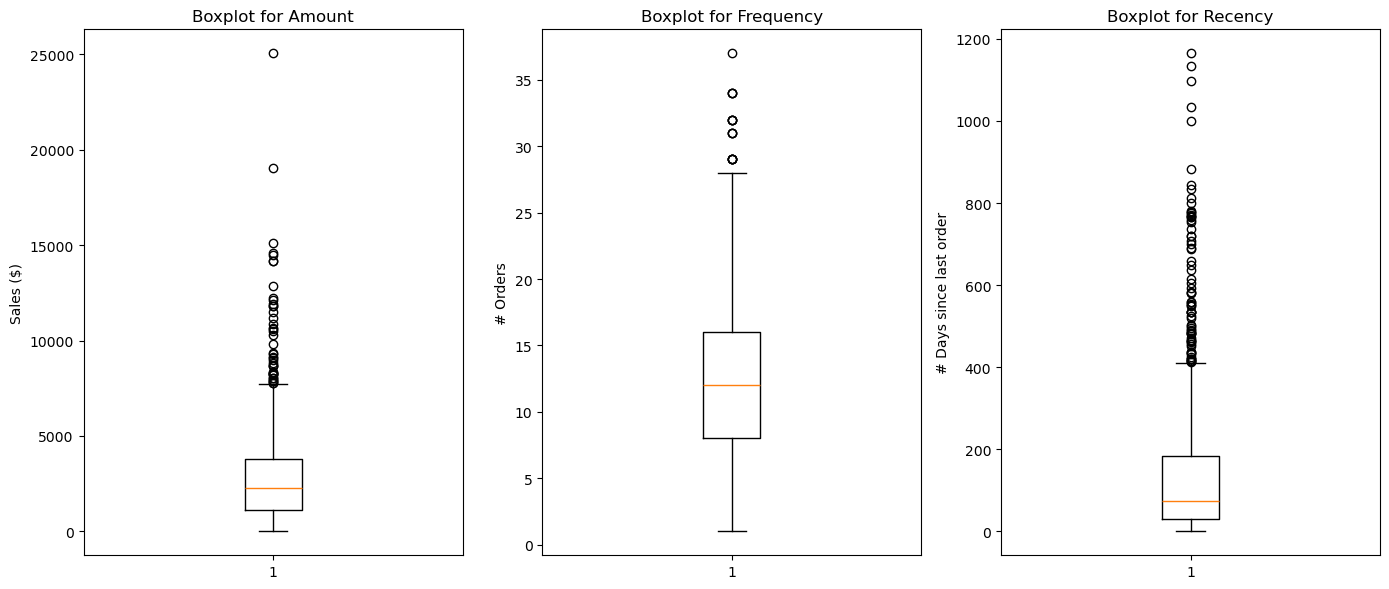

In [375]:
# Create a boxplot for each parameter
plt.figure(figsize=(14, 6))

# Boxplot for Amount
plt.subplot(1, 3, 1)
plt.boxplot(rfm_df['Amount'])
plt.title('Boxplot for Amount')
plt.ylabel('Sales ($)')

# Boxplot for Frequency
plt.subplot(1, 3, 2)
plt.boxplot(rfm_df['Frequency'])
plt.title('Boxplot for Frequency')
plt.ylabel('# Orders')

# Boxplot for Recency
plt.subplot(1, 3, 3)
plt.boxplot(rfm_df['Recency'])
plt.title('Boxplot for Recency')
plt.ylabel('# Days since last order')

plt.tight_layout()
plt.show()


Remove each feature's (statistical) outliers using the Interquartile Range (IQR is the difference between the upper quartile and the lower quartile).

In [376]:
def claculate_iqr_bounds(df_column):
    # Calculate Q1, Q3, and IQR
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return (lower_bound, upper_bound)

In [377]:
# Remove each feature's (statistical) outliers using the Interquartile Range.

# Save all the rows that classify as outliers.
outliers = {}                                                                                      # The outliers for each feature will be saved here
for feature in ['Amount', 'Frequency', 'Recency']:
    lower_bound, upper_bound = claculate_iqr_bounds(rfm_df[feature])                               # Calculate IQR bounds
    outliers[feature] = rfm_df[(rfm_df[feature] < lower_bound) | (rfm_df[feature] > upper_bound)]  # Save lines with outliers

# Merge all DataFrames with outliers into one
outliers_df = pd.concat(outliers.values())

# Filter out rows with CustomerIDs present in outliers_df
rfm_df = rfm_df[~rfm_df['CustomerID'].isin(outliers_df['CustomerID'])]

#### Feature scaling
Because of the nature of the algorithm, it is crucial to rescale the variables so that they have a comparable scale. There are two common ways of rescaling: Min-Max and Standardisation (mean-0, sigma-1)

Here, we will use Standardisation Scaling.

In [378]:
# Rescaling the attributes
rfm_df = rfm_df[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
display(rfm_df_scaled.shape)

# After fit_transform we need to change the type back from numpy.ndarray to pd.DataFrame
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

(669, 3)

,Amount,Frequency,Recency
0,1.801976,-0.263883,0.877375
1,-0.863258,0.467122,-0.812039
2,-0.429132,-0.081132,1.645291
3,1.520124,1.015375,-0.443440
4,-0.916282,-0.081132,-0.586784
